# Module 3 Project

## Team ????

## Contributors : John Naujoks, Mando Iwanaga

----

**Import necessary packages**

In [4]:
# General setup
import pandas as pd
import numpy as np
import re

# Modeling tools
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV
import xgboost as xgb
from sklearn.linear_model import LogisticRegression

# Preprocessing and scoring
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_curve, auc, confusion_matrix, average_precision_score
from sklearn.metrics import log_loss, roc_auc_score, classification_report
from sklearn.preprocessing import OneHotEncoder
from imblearn.over_sampling import SMOTE

# Visualization
from sklearn.tree import export_graphviz
from sklearn.externals.six import StringIO 
from IPython.display import Image  
from sklearn import tree
import pydotplus
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

# EDA and Data Cleaning with scrape of 2015-2019 Data
***

**We obtained our dataset through a combination of using boardgamegeek API Python package<br> and scraping  the boardgamegeek website for missing and additional data.**

In [5]:
#Complete dataset is saved in data folder as bgg_complete_1419.csv

bgg = pd.read_csv('data/bgg_complete_1419.csv', index_col=0)

In [6]:
bgg.head()

,rank,id,name,age,avg_time,min_players,max_players,mechanic,category,weight,year,geek,avg,num_rev
0,NaN,246783,Wildlands: The Unquiet Dead,14,60,2,4,[],"['Expansion for Base-game', 'Miniatures']",2.0,2018,5.653,7.44,108.0
1,12558.0,205776,Gentleman's Deal,12,60,5,9,"['Partnerships', 'Voting']","['Bluffing', 'Negotiation', 'Party Game']",1.0,2016,5.514,6.21,47.0
2,13663.0,188129,Heroes and Tricks,8,25,2,6,"['Hand Management', 'Trick-taking']","['Deduction', 'Fantasy']",0.0,2017,5.504,5.67,83.0
3,13323.0,206083,Ragers: Champions of the Arena,14,20,2,2,"['Rock-Paper-Scissors', 'Simultaneous Action S...","['Card Game', 'Fantasy', 'Fighting']",1.0,2016,5.507,5.98,36.0
4,6390.0,201006,Bumúntú,8,30,2,5,['Action / Movement Programming'],"['Animals', 'Educational']",2.0,2019,5.603,7.15,95.0


In [7]:
# Drop rows with no rank, as they are expansions to games, and not individual games
to_drop = bgg[bgg['rank'].isna()]
bgg.drop(to_drop.index, axis=0, inplace=True)
len(bgg)

3142

In [8]:
# Filling in median value for rows with 0 weight given
bgg.loc[bgg["weight"] == 0] = bgg['weight'].median()

In [9]:
# Double checking that it pulled only those for the correct year
len(bgg[bgg['year'] < 2015]), len(bgg)

(156, 3142)

In [10]:
# Dropping rows with dates prior to 2015 (bad API pull)
to_drop = bgg[bgg['year'] < 2015]
bgg.drop(to_drop.index, axis=0, inplace=True)

In [11]:
len(bgg)

2986

In [12]:
bgg.describe()

,rank,id,age,avg_time,min_players,max_players,weight,year,geek,avg,num_rev
count,2986.000000,2986.000000,2986.000000,2986.000000,2986.000000,2986.000000,2986.000000,2986.000000,2986.000000,2986.000000,2986.000000
mean,5627.139652,199141.554588,10.568989,125.158741,1.877763,5.687207,2.185205,2016.504689,5.844739,6.967579,844.825184
std,3892.970305,34978.264744,3.419438,2210.236276,0.693686,20.202906,0.777614,1.194408,0.459034,0.757621,2586.059547
min,1.000000,16271.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2015.000000,4.779000,2.440000,30.000000
25%,2452.500000,176533.500000,8.000000,30.000000,1.000000,4.000000,1.600000,2015.000000,5.565000,6.510000,92.000000
50%,5066.500000,197185.000000,12.000000,50.000000,2.000000,4.000000,2.062500,2016.000000,5.653000,6.960000,190.000000
75%,7925.500000,225122.250000,13.000000,90.000000,2.000000,5.000000,2.708300,2017.000000,5.940000,7.430000,539.500000
max,17135.000000,272409.000000,21.000000,120000.000000,8.000000,999.000000,5.000000,2019.000000,8.610000,9.600000,51149.000000


In [13]:
len(bgg[bgg['num_rev'] < 50])

255

In [14]:
# Removing rows with less than 50 reviews
to_drop = bgg[bgg['num_rev'] < 50]
bgg.drop(to_drop.index, axis=0, inplace=True)

In [15]:
bgg.head()

,rank,id,name,age,avg_time,min_players,max_players,mechanic,category,weight,year,geek,avg,num_rev
4,6390.0,201006.0,Bumúntú,8.0,30.0,2.0,5.0,['Action / Movement Programming'],"['Animals', 'Educational']",2.0000,2019.0,5.603,7.15,95.0
7,3426.0,256839.0,VektoRace,12.0,120.0,2.0,4.0,"['Action / Movement Programming', 'Simulation']","['Racing', 'Sports']",2.3333,2018.0,5.785,8.32,196.0
8,6801.0,258104.0,Tribes: Dawn of Humanity,10.0,45.0,2.0,4.0,"['Grid Movement', 'Tile Placement']","['Ancient', 'Civilization', 'Exploration', 'Pr...",2.4000,2018.0,5.590,6.80,99.0
11,5451.0,241796.0,Nut So Fast,8.0,20.0,3.0,6.0,['Pattern Recognition'],"['Action / Dexterity', 'Party Game']",1.0000,2018.0,5.636,7.03,157.0
14,9524.0,233206.0,Werebeasts,8.0,15.0,3.0,10.0,['Set Collection'],"['Deduction', 'Party Game']",1.5000,2018.0,5.543,6.30,94.0


In [16]:
bgg['mechanic'] = bgg['mechanic'].apply(lambda x: re.sub("\[|\]|'","", x).replace(" ",""))
bgg['category'] = bgg['category'].apply(lambda x: re.sub("\[|\]|'","", x).replace(" ",""))

In [17]:
bgg = bgg.reset_index()
bgg.head()

,index,rank,id,name,age,avg_time,min_players,max_players,mechanic,category,weight,year,geek,avg,num_rev
0,4,6390.0,201006.0,Bumúntú,8.0,30.0,2.0,5.0,Action/MovementProgramming,"Animals,Educational",2.0000,2019.0,5.603,7.15,95.0
1,7,3426.0,256839.0,VektoRace,12.0,120.0,2.0,4.0,"Action/MovementProgramming,Simulation","Racing,Sports",2.3333,2018.0,5.785,8.32,196.0
2,8,6801.0,258104.0,Tribes: Dawn of Humanity,10.0,45.0,2.0,4.0,"GridMovement,TilePlacement","Ancient,Civilization,Exploration,Prehistoric,T...",2.4000,2018.0,5.590,6.80,99.0
3,11,5451.0,241796.0,Nut So Fast,8.0,20.0,3.0,6.0,PatternRecognition,"Action/Dexterity,PartyGame",1.0000,2018.0,5.636,7.03,157.0
4,14,9524.0,233206.0,Werebeasts,8.0,15.0,3.0,10.0,SetCollection,"Deduction,PartyGame",1.5000,2018.0,5.543,6.30,94.0


In [18]:
mechanics_df = pd.DataFrame(bgg['mechanic'].str.split(',').tolist(), index=bgg.index).stack()
mechanics_df = mechanics_df.reset_index()
mechanics_df = mechanics_df.drop('level_1', axis=1)
mechanics_df.columns = ['id', 'mechanics']

In [19]:
mechanics_df.head()

,id,mechanics
0,0,Action/MovementProgramming
1,1,Action/MovementProgramming
2,1,Simulation
3,2,GridMovement
4,2,TilePlacement


In [20]:
encoder = OneHotEncoder(categories="auto").fit(mechanics_df[["mechanics"]])

In [21]:
mech_ohe = pd.DataFrame(encoder.transform(mechanics_df[["mechanics"]]).toarray(),
                   columns=encoder.get_feature_names(["mech"]))

mech_ohe_df = pd.concat([mechanics_df.drop("mechanics", axis=1), mech_ohe], axis=1)

mech_dedup = mech_ohe_df.groupby("id")[mech_ohe.columns].agg("sum").reset_index()

mech_dedup.head()

,id,mech_,mech_Acting,mech_Action/MovementProgramming,mech_ActionPointAllowanceSystem,mech_Area-Impulse,mech_AreaControl/AreaInfluence,mech_AreaEnclosure,mech_AreaMovement,mech_Auction/Bidding,...,mech_Storytelling,mech_TakeThat,mech_TilePlacement,mech_TimeTrack,mech_Trading,mech_Trick-taking,mech_VariablePhaseOrder,mech_VariablePlayerPowers,mech_Voting,mech_WorkerPlacement
0,0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [22]:
cat_df = pd.DataFrame(bgg['category'].str.split(',').tolist(), index=bgg.index).stack()
cat_df = cat_df.reset_index()
cat_df = cat_df.drop('level_1', axis=1)
cat_df.columns = ['id', 'category']

In [23]:
cat_df.head()

,id,category
0,0,Animals
1,0,Educational
2,1,Racing
3,1,Sports
4,2,Ancient


In [24]:
encoder_2 = OneHotEncoder(categories="auto").fit(cat_df[["category"]])

In [25]:
cat_ohe = pd.DataFrame(encoder_2.transform(cat_df[["category"]]).toarray(),
                   columns=encoder_2.get_feature_names(["cat"]))

cat_ohe_df = pd.concat([cat_df.drop("category", axis=1), cat_ohe], axis=1)

cat_dedup = cat_ohe_df.groupby("id")[cat_ohe.columns].agg("sum").reset_index()

cat_dedup.head()

,id,cat_,"cat_""ChildrensGame""",cat_AbstractStrategy,cat_Action/Dexterity,cat_Adventure,cat_AgeofReason,cat_AmericanCivilWar,cat_AmericanIndianWars,cat_AmericanRevolutionaryWar,...,cat_Transportation,cat_Travel,cat_Trivia,cat_VideoGameTheme,cat_VietnamWar,cat_Wargame,cat_WordGame,cat_WorldWarI,cat_WorldWarII,cat_Zombies
0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,3,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [26]:
bgg_complete = pd.concat([bgg, mech_dedup, cat_dedup], axis=1)
bgg_complete = bgg_complete.drop(['mechanic','category'], axis=1)
bgg_complete.shape

(2731, 153)

**Our cleaned dataset now consists of data from the year 2016 through 2019**

---

### Prep for Modeling

In [27]:
bgg_complete['geek'].describe()

count    2731.000000
mean        5.873798
std         0.469515
min         4.779000
25%         5.582000
50%         5.676000
75%         5.989000
max         8.610000
Name: geek, dtype: float64

In [28]:
#Create classiying column called top_score using the greek score, the top 25% will be 1 and the rest will be 0

bgg_complete['top_score'] = bgg['geek'].apply(lambda x: 1 if x > 5.989000 else 0)

In [29]:
#define which predictors to drop

drop = ['index','rank', 'id', 'name', 'year', 'geek',
        'age', 'avg', 'num_rev', 'mech_', 'cat_', 'top_score']

to_drop = drop + cat_dedup.columns.tolist()

In [30]:
#Define our X and y 

X = bgg_complete.drop(to_drop, axis=1)
y = bgg_complete['top_score']

In [31]:
#train-test split

X_train, X_test, y_train, y_test = train_test_split(X, y)

*** 

## Modeling

**We will try several classification models for comparisons**

---

## Decision Tree

In [32]:
clf = DecisionTreeClassifier()

clf.fit(X_train, y_train)

y_pred_t = clf.predict_proba(X_test)

In [33]:
#Print feature importance percentages

vals = clf.feature_importances_.tolist()
best = []
for i, val in enumerate(vals):
    if round(val * 100, 2) > 1:
        print(X.columns[i] + ": " + str(round(val * 100, 2)) + "%")
        best.append(val)

avg_time: 6.54%
min_players: 3.07%
max_players: 8.63%
weight: 36.48%
mech_Action/MovementProgramming: 1.09%
mech_ActionPointAllowanceSystem: 1.19%
mech_AreaControl/AreaInfluence: 1.89%
mech_AreaMovement: 1.22%
mech_Auction/Bidding: 1.14%
mech_CardDrafting: 1.84%
mech_CooperativePlay: 1.43%
mech_Deck/PoolBuilding: 2.07%
mech_DiceRolling: 1.76%
mech_GridMovement: 1.15%
mech_HandManagement: 2.95%
mech_Hex-and-Counter: 1.43%
mech_ModularBoard: 1.36%
mech_Partnerships: 1.17%
mech_PressYourLuck: 1.33%
mech_Route/NetworkBuilding: 1.39%
mech_SetCollection: 2.93%
mech_Storytelling: 1.04%
mech_TakeThat: 1.36%
mech_TilePlacement: 1.91%


**Evaluate Decision Tree**

Log loss: 10.114858603459293

ROC AUC Score: 0.6075922371507784


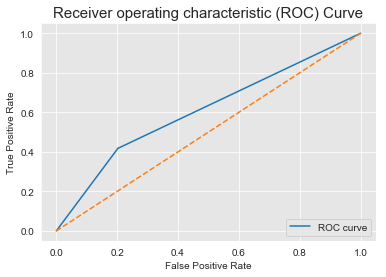

In [34]:
#Seaborn's beautiful styling
sns.set_style("darkgrid", {"axes.facecolor": ".9"})

print(f"Log loss: {log_loss(y_test, y_pred_t)}")
print(f"\nROC AUC Score: {roc_auc_score(y_test, y_pred_t[:,1])}")
fpr, tpr, thresholds = roc_curve(y_test, y_pred_t[:,1])
#Plot
plt.plot(fpr, tpr, label='ROC curve')
# this is just a diagonal
plt.plot([0, 1], [0, 1], linestyle='--');
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.title('Receiver operating characteristic (ROC) Curve', fontsize=15)
plt.show;

**Visualization of Decision Tree**

In [39]:
#dot_data = StringIO()
#export_graphviz(clf, out_file=dot_data, filled=True, rounded=True,special_characters=True)
#graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
#Image(graph.create_png())

---

## Random Forest Classifier

In [40]:
forest = RandomForestClassifier(n_estimators=100, max_depth=5)

forest.fit(X_train, y_train)

y_pred_forest = forest.predict_proba(X_test)
y_pred_f = forest.predict(X_test)

In [41]:
#Print feature importance percentages

vals = forest.feature_importances_.tolist()
best = []
for i, val in enumerate(vals):
    if round(val * 100, 2) > 1:
        print(X.columns[i] + ": " + str(round(val * 100, 2)) + "%")
        best.append(val)

avg_time: 11.63%
min_players: 5.98%
max_players: 5.9%
weight: 23.04%
mech_ActionPointAllowanceSystem: 1.4%
mech_AreaControl/AreaInfluence: 2.0%
mech_AreaMovement: 1.33%
mech_CardDrafting: 10.36%
mech_CooperativePlay: 3.09%
mech_Deck/PoolBuilding: 3.5%
mech_HandManagement: 1.5%
mech_Hex-and-Counter: 2.16%
mech_ModularBoard: 1.31%
mech_SetCollection: 1.21%
mech_Storytelling: 2.14%
mech_VariablePhaseOrder: 1.14%
mech_VariablePlayerPowers: 3.41%
mech_WorkerPlacement: 4.72%


**Evaluate Random Forest**

Log loss: 0.48779272149872827

ROC AUC Score: 0.7552320675105485


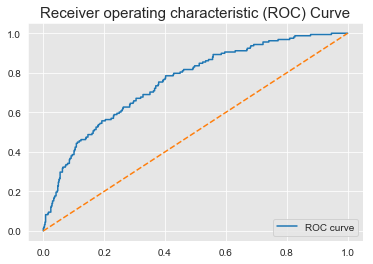

In [42]:
#Seaborn's beautiful styling
sns.set_style("darkgrid", {"axes.facecolor": ".9"})

print(f"Log loss: {log_loss(y_test, y_pred_forest)}")
print(f"\nROC AUC Score: {roc_auc_score(y_test, y_pred_forest[:,1])}")
fpr, tpr, thresholds = roc_curve(y_test, y_pred_forest[:,1])
#Plot
plt.plot(fpr, tpr, label='ROC curve')
# this is just a diagonal
plt.plot([0, 1], [0, 1], linestyle='--');
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.title('Receiver operating characteristic (ROC) Curve', fontsize=15)
plt.show;

---

## Gradient Boosting Classifier

In [43]:
boost = GradientBoostingClassifier(learning_rate=.01)

boost.fit(X_train, y_train)

boost_pred = boost.predict_proba(X_test)

In [44]:
#Print feature importance percentages

vals = boost.feature_importances_.tolist()
best = []
for i, val in enumerate(vals):
    if round(val * 100, 2) > 1:
        print(X.columns[i] + ": " + str(round(val * 100, 2)) + "%")
        best.append(val)

min_players: 2.93%
max_players: 3.47%
weight: 72.67%
mech_CardDrafting: 8.35%
mech_Hex-and-Counter: 8.58%
mech_Route/NetworkBuilding: 1.4%
mech_VariablePlayerPowers: 1.29%


**Evaluate Gradient Boosting**

Log loss: 0.49023753543777604

ROC AUC Score: 0.7500241109101868


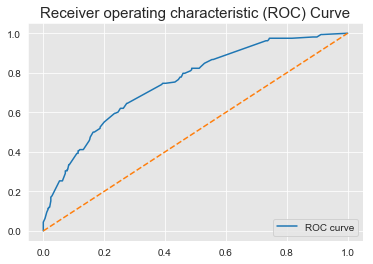

In [45]:
#Seaborn's beautiful styling
sns.set_style("darkgrid", {"axes.facecolor": ".9"})

print(f"Log loss: {log_loss(y_test, boost_pred)}")
print(f"\nROC AUC Score: {roc_auc_score(y_test, boost_pred[:,1])}")
fpr, tpr, thresholds = roc_curve(y_test, boost_pred[:,1])
#Plot
plt.plot(fpr, tpr, label='ROC curve')
# this is just a diagonal
plt.plot([0, 1], [0, 1], linestyle='--');
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.title('Receiver operating characteristic (ROC) Curve', fontsize=15)
plt.show;

---

## XG Boost Classifier

In [46]:
x_boost = xgb.XGBClassifier(learning_rate=.1)

x_boost.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [47]:
x_pred = x_boost.predict_proba(X_test)

In [48]:
#Print feature importance percentages

vals = x_boost.feature_importances_.tolist()
best = []
for i, val in enumerate(vals):
    if round(val * 100, 2) > 1:
        print(X.columns[i] + ": " + str(round(val * 100, 2)) + "%")
        best.append(val)

avg_time: 5.42%
min_players: 6.73%
max_players: 9.53%
weight: 38.32%
mech_Action/MovementProgramming: 1.68%
mech_ActionPointAllowanceSystem: 1.5%
mech_CardDrafting: 3.36%
mech_Chit-PullSystem: 2.24%
mech_CooperativePlay: 1.31%
mech_GridMovement: 1.12%
mech_HandManagement: 1.12%
mech_Hex-and-Counter: 3.74%
mech_HiddenTraitor: 1.87%
mech_LineDrawing: 1.31%
mech_Partnerships: 1.87%
mech_PatternRecognition: 1.87%
mech_PressYourLuck: 1.87%
mech_Roll/SpinandMove: 1.68%
mech_Route/NetworkBuilding: 1.31%
mech_SetCollection: 1.31%
mech_VariablePlayerPowers: 1.31%


**Evaluate XG Boost**

Log loss: 0.45340333600688076

ROC AUC Score: 0.7740687160940325


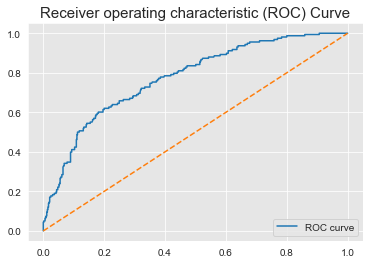

In [49]:
#Seaborn's beautiful styling
sns.set_style("darkgrid", {"axes.facecolor": ".9"})

print(f"Log loss: {log_loss(y_test, x_pred)}")
print(f"\nROC AUC Score: {roc_auc_score(y_test, x_pred[:,1])}")
fpr, tpr, thresholds = roc_curve(y_test, x_pred[:,1])
#Plot
plt.plot(fpr, tpr, label='ROC curve')
# this is just a diagonal
plt.plot([0, 1], [0, 1], linestyle='--');
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.title('Receiver operating characteristic (ROC) Curve', fontsize=15)
plt.show;

---

## Logistic Regression

In [50]:
#logreg = LogisticRegression(solver='liblinear', penalty="l1") #Starter code
#model_log = logreg.fit(X_train, y_train)
#print(model_log) #Preview model params

In [51]:
#logreg_pred = logreg.predict(X_test)

In [52]:
#y_score = logreg.fit(X_train, y_train).decision_function(X_test)

In [53]:
#fpr, tpr, thresholds = roc_curve(y_test, y_score)

**Evaluate Logistic Regression**

In [54]:
##Seaborn's beautiful styling
#sns.set_style("darkgrid", {"axes.facecolor": ".9"})

#print(f"Log loss: {log_loss(y_test, x_pred)}")
#print(f"\nROC AUC Score: {roc_auc_score(y_test, x_pred[:,1])}")
#fpr, tpr, thresholds = roc_curve(y_test, x_pred[:,1])
##Plot
#plt.plot(fpr, tpr, label='ROC curve')
## this is just a diagonal
#plt.plot([0, 1], [0, 1], linestyle='--');
#plt.xlabel('False Positive Rate')
#plt.ylabel('True Positive Rate')
#plt.legend(loc="lower right")
#plt.title('Receiver operating characteristic (ROC) Curve', fontsize=15)
#plt.show;

**SMOTE for Logistic Regression**

In [55]:
#print(y.value_counts()) #Previous original class distribution
#X_resampled, y_resampled = SMOTE().fit_sample(X, y) 
#print(pd.Series(y_resampled).value_counts())

In [56]:
#X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled)


In [57]:
#logreg_pred = logreg.predict(X_test)
#y_log_pred_smote = logreg.predict_proba(X_test)

In [58]:
#y_score = logreg.fit(X_train, y_train).decision_function(X_test)

#fpr, tpr, thresholds = roc_curve(y_test, y_score)

**Evaluate Logistic Regression after SMOTE**

In [59]:
##Seaborn's beautiful styling
#sns.set_style("darkgrid", {"axes.facecolor": ".9"})

#print(f"Log loss: {log_loss(y_test, y_log_pred_smote)}")
#print(f"\nROC AUC Score: {roc_auc_score(y_test, logreg_pred[:,1])}")
#fpr, tpr, thresholds = roc_curve(y_test, logreg_pred[:,1])
##Plot
#plt.plot(fpr, tpr, label='ROC curve')
## this is just a diagonal
#plt.plot([0, 1], [0, 1], linestyle='--');
#plt.xlabel('False Positive Rate')
#plt.ylabel('True Positive Rate')
#plt.legend(loc="lower right")
#plt.title('Receiver operating characteristic (ROC) Curve', fontsize=15)
#plt.show;

---

## K-Nearest Neighbors for assessing similarity to other games

In [60]:
from sklearn.neighbors import KNeighborsClassifier

kn = KNeighborsClassifier(n_neighbors=3)
kn.fit(X, y)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=3, p=2,
           weights='uniform')

In [61]:
guess = np.array(X.iloc[25]).reshape(1,-1)

In [62]:
kn.kneighbors(guess)[1][0]

array([  25, 1937,  977])

In [63]:
bgg_complete.loc[25]['name'], bgg_complete.loc[1937]['name']

('Ladder 29', 'Custom Heroes')

In [ ]:
from sklearn.decomposition import PCA
pca = PCA(n_components=1) # Number of principal components required
pca.fit(X)

In [ ]:
print(pca.explained_variance_ratio_.tolist())

---

## GridSearchCV

**Run GridSearch on models to find the best parameters**

**Decision Tree**

In [253]:
param_grid_clf = {
    "criterion": ["gini", "entropy"],
    "max_depth": [3, 4, 5],
    "min_samples_split": [5, 6, 7],
    "min_samples_leaf": [1, 2]
}

In [254]:
gs_clf = GridSearchCV(clf, param_grid_dtc, cv=3)

In [255]:
gs_clf.fit(X_train, y_train)

In [256]:
gs_clf.best_params_

**Random Forest**

In [57]:
param_grid_forest = {
    "n_estimators": [25, 28, 30, 32],
    "criterion": ["gini", "entropy"],
    "max_depth": [None, 3],
    "min_samples_split": [4, 5, 6],
    "min_samples_leaf": [1, 2]
}

In [58]:
gs_forest = GridSearchCV(forest, param_grid_forest, cv=3)

In [59]:
gs_forest.fit(X_train, y_train)

In [60]:
gs_forest.best_params_

**Gradient Boosting**

In [ ]:
param_grid_gb = {
    
}

In [ ]:
gs_boost = GridSearchCV(boost, param_grid_gb, cv=3)

In [ ]:
gs_boost.fit(X_train, y_train)

In [ ]:
gs_boost.best_params_

**XGBoost**

In [61]:
param_grid_xgb = {
    "learning_rate": [0.1, 0.2, 0.3],
    'max_depth': [4, 5, 6],
    'min_child_weight': [1, 2, 3],
    'subsample': [1, 2, 3],
    'n_estimators': [150, 200],
}

In [62]:
gs_xgb = GridSearchCV(x_boost, param_grid_xgb, cv=3)

In [63]:
gs_xgb.fit(X_train, y_train)

In [64]:
gs_xgb.best_params_

**Logistic Regression**

In [ ]:
#logreg = LogisticRegression(solver='lbfgs')

In [232]:
#param_grid_logreg = {
 #   "max_iter": [170, 175, 180],
  #  "penalty": ["l1", "l2"]
#}

In [233]:
#gs_tree_logreg = GridSearchCV(logreg, param_grid_logreg, cv=3)

In [2]:
#gs_tree_logreg.fit(X_train, y_train)

In [3]:
#gs_tree_logreg.best_params_